**1. Importing libraries and reading data**

In [457]:
import numpy as np
import pandas as pd
from statsmodels.tsa.vector_ar.var_model import VAR
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sys
import re

In [458]:
US_GDP = pd.read_excel("/content/US_GDP.xlsx")
CAN_GDP = pd.read_excel("/content/canada_GDP.xlsx")
CPI = pd.read_excel("/content/CPI.xlsx")
FOREX = pd.read_excel("/content/FOREX.xlsx")
overnight_rate = pd.read_excel("/content/overnight_rate.xlsx")
unemployment_rate = pd.read_excel("/content/unemployment_rate.xlsx")

**2. Processing data**

In [459]:
#function to format the time series
def formalize_time(dataset):
  dataset["Time"] = pd.to_datetime(dataset["Time"])
  quarter =  dataset["Time"].dt.quarter.astype(str)
  year = dataset["Time"].dt.year.astype(str)
  dataset["Time"] = "Q" + quarter + "- " +  year
  return dataset.set_index("Time")

# function to calculate the moving average
def quarterly_average(dataset):
  dataset["Time"] = pd.to_datetime(dataset["Time"])
  dataset = dataset.set_index("Time")
  dataset = dataset.resample("QS").mean()
  return formalize_time(dataset.reset_index())

In [460]:
overnight_rate['Bank policy rate'] = pd.to_numeric(overnight_rate['Bank policy rate'], errors='coerce')
overnight_rate = quarterly_average(overnight_rate)
US_GDP = quarterly_average(US_GDP)
CPI = quarterly_average(CPI)
FOREX = quarterly_average(FOREX)
unemployment_rate = quarterly_average(unemployment_rate)
CAN_GDP['Time'] = CAN_GDP["Time"].str[:2] + "-" + CAN_GDP["Time"].str[2:]
CAN_GDP = CAN_GDP.set_index("Time")

In [461]:
CAN_GDP.columns = ["GDP at market price", "real GDP"]
datasets = [US_GDP, CPI , FOREX, overnight_rate, unemployment_rate]
for i in datasets:
  CAN_GDP = pd.concat([CAN_GDP,i], axis=1)
data_undiff = CAN_GDP[:-1]
data_undiff = data_undiff.drop(columns={"GDP at market price", "CPI core"})

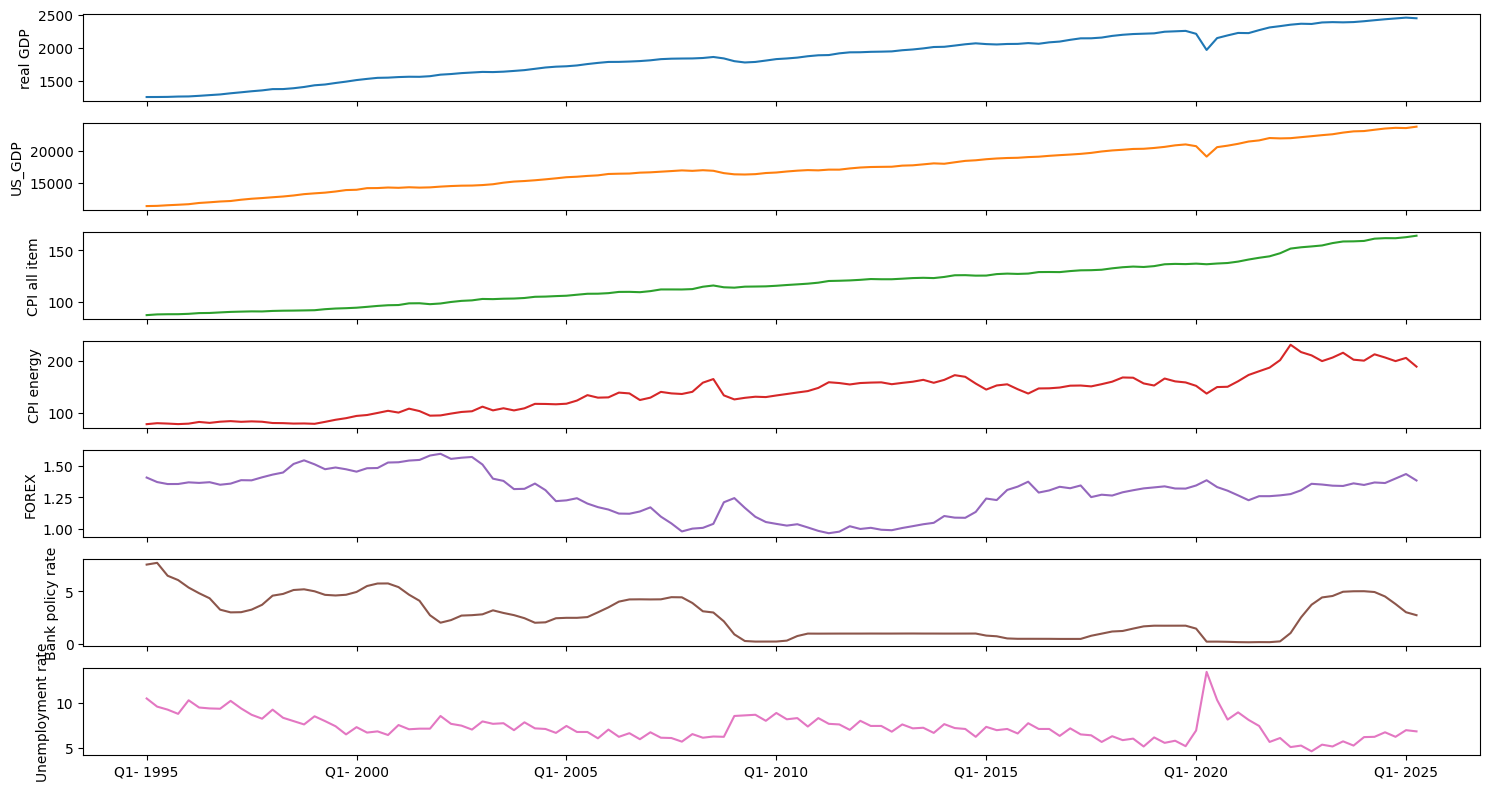

In [462]:
fig,ax = plt.subplots(7, figsize=(15,8), sharex=True)
plot_cols = data_undiff.columns
data_undiff[plot_cols].plot(subplots=True, legend=False, ax=ax)
for a in range(len(ax)):
    ax[a].set_ylabel(plot_cols[a])
ax[-1].set_xlabel('')
plt.tight_layout()
plt.show()

In [463]:
data_undiff.columns

Index(['real GDP', 'US_GDP', 'CPI all item', 'CPI energy', 'FOREX',
       'Bank policy rate', 'Unemployment rate'],
      dtype='object')

**3. Checking stationarity & Differencing data**

In [464]:
#defining the ADF function for stationarity checking
def ADF_test(data):
  test_stat, p_val = [], []
  cv_1pct, cv_5pct, cv_10pct = [], [], []
  for c in data.columns:
      adf_res = adfuller(data[c].dropna())
      test_stat.append(adf_res[0])
      p_val.append(adf_res[1])
      cv_1pct.append(adf_res[4]['1%'])
      cv_5pct.append(adf_res[4]['5%'])
      cv_10pct.append(adf_res[4]['10%'])
  adf_res_df = pd.DataFrame({'Test statistic': test_stat,
                            'p-value': p_val,
                            'Critical value - 1%': cv_1pct,
                            'Critical value - 5%': cv_5pct,
                            'Critical value - 10%': cv_10pct},
                          index=data.columns).T
  return adf_res_df.round(4)

The ADF test for stationarity, H0: series is non-stationary

In [465]:
ADF_test(data_undiff)

,real GDP,US_GDP,CPI all item,CPI energy,FOREX,Bank policy rate,Unemployment rate
Test statistic,-0.6732,0.2306,1.5418,-0.8632,-1.5842,-3.7394,-3.9307
p-value,0.8536,0.9739,0.9977,0.7998,0.4915,0.0036,0.0018
Critical value - 1%,-3.4861,-3.4861,-3.4912,-3.4924,-3.4861,-3.4861,-3.4875
Critical value - 5%,-2.8859,-2.8859,-2.8882,-2.8887,-2.8859,-2.8859,-2.8866
Critical value - 10%,-2.5798,-2.5798,-2.5810,-2.5813,-2.5798,-2.5798,-2.5801


reject the null hypothesis for *Bank policy rate *and* Unemployment rate*, which means these two series are stationary

In [466]:
data=data_undiff.copy()
for i in data.columns.drop("Unemployment rate"):
  data[i] = data[i].diff()
ADF_test(data[1:])

,real GDP,US_GDP,CPI all item,CPI energy,FOREX,Bank policy rate,Unemployment rate
Test statistic,-12.7292,-13.1885,-2.1905,-3.6714,-8.7212,-5.0627,-3.9521
p-value,0.0000,0.0000,0.2097,0.0045,0.0000,0.0000,0.0017
Critical value - 1%,-3.4861,-3.4861,-3.4912,-3.4924,-3.4861,-3.4865,-3.4880
Critical value - 5%,-2.8859,-2.8859,-2.8882,-2.8887,-2.8859,-2.8862,-2.8868
Critical value - 10%,-2.5798,-2.5798,-2.5810,-2.5813,-2.5798,-2.5799,-2.5802


In [467]:
#CPI all item needs second differencing
data["CPI all item"].diff()

,CPI all item
Time,
Q1- 1995,NaN
Q2- 1995,NaN
Q3- 1995,-0.533333
Q4- 1995,-0.133333
Q1- 1996,0.333333
...,...
Q2- 2024,1.800000
Q3- 2024,-1.700000
Q4- 2024,-0.566667


**3.5 Granger Causality test**

In [468]:
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests

def granger_causation_matrix(data, variables, p, test = 'ssr_chi2test', verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], p, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(p)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [469]:
granger_causation_matrix(data[2:], data.columns, 17).loc[["real GDP_y","CPI all item_y"]]

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print resul

,real GDP_x,US_GDP_x,CPI all item_x,CPI energy_x,FOREX_x,Bank policy rate_x,Unemployment rate_x
real GDP_y,1.0,0.3825,0.0687,0.0108,0.0072,0.7613,0.0002
CPI all item_y,0.0,0.0000,1.0000,0.0033,0.0359,0.0231,0.0000


According to the Granger causality test, CPI energy, FOREX, and Unemployment rate cause real GDP. Meanwhile, Canadian GDP, US GDP, CPI energy, FOREX, Bank policy rate, and Unemployment rate cause CPI for all item.

**4. Splitting data & find the optimal lags P**

In [470]:
print(len(data))
train, test = data[:110], data[-12:]


122


In [471]:
def select_p(train,max):
    aic= []
    model = VAR(train)
    p = np.arange(1,max)
    for i in p:
        result = model.fit(i)
        aic.append(result.aic)
    lags_metrics_df = pd.DataFrame({'AIC': aic},
                                   index=p)
    fig, ax = plt.subplots(1, 1, figsize=(10,8), sharex=True)
    lags_metrics_df.plot(subplots=True, ax=ax, marker='o')
    plt.tight_layout()
    print(lags_metrics_df.idxmin(axis=0))

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


AIC    4
dtype: int64


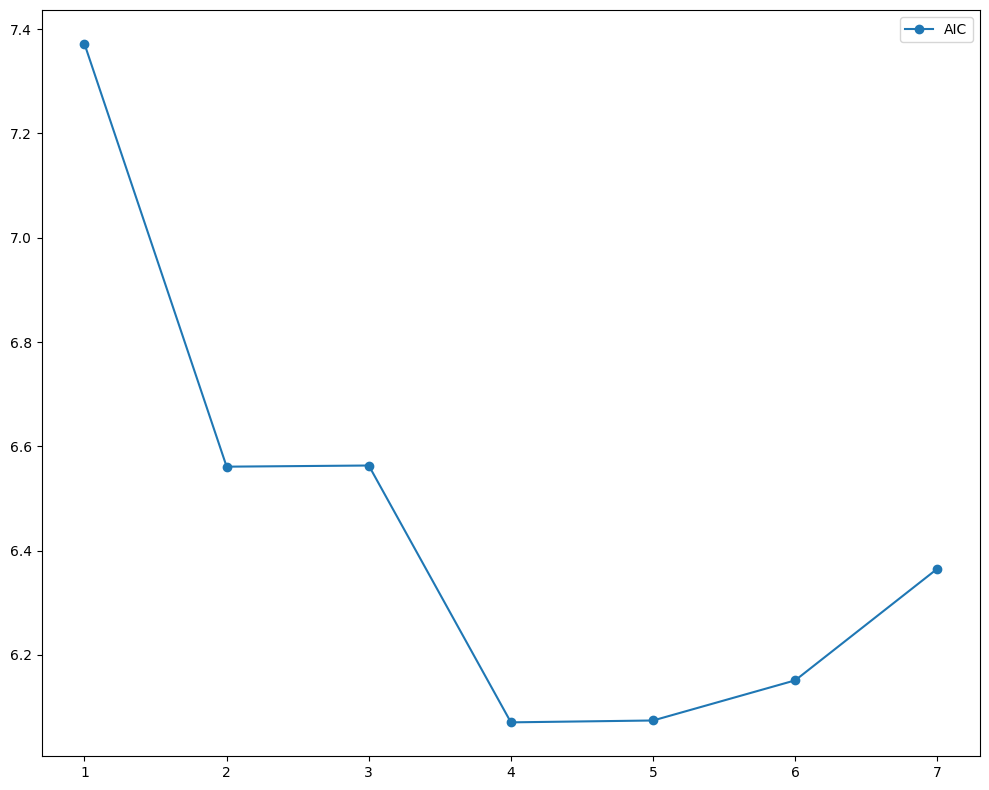

In [472]:
select_p(train[2:],8)

optimal number of lags should be around 4

**5. Indroducing dummy variables and Model fitting**

In [473]:
variable_to_forecast = ["real GDP", "CPI all item"]

In [474]:
model_sample = data.copy()
model_sample = model_sample[1:]
exog_dummies = pd.DataFrame(index=model_sample.index)

formatted_index = model_sample.index.str.replace(
      r'Q(\d)[\s-]*(\d{4})', r'\2Q\1', regex=True)
model_sample.index = pd.PeriodIndex(formatted_index, freq='Q')

pandemic_shock_dates_str = ['Q4-2019', 'Q1-2020', 'Q2-2020', 'Q3-2020']

exog_dummies = pd.DataFrame(index=model_sample.index)
print(f"Creating {len(pandemic_shock_dates_str)} total pulse dummies:")
for date_str in pandemic_shock_dates_str:
  try:
      formatted_date_str = re.sub(r'Q(\d)[\s-]*(\d{4})', r'\2Q\1', date_str)
      date_period = pd.Period(formatted_date_str, freq='Q')

      dummy_name = f'D_{formatted_date_str}' # e.g., D_2019Q4
      exog_dummies[dummy_name] = 0

      if date_period in exog_dummies.index:
          exog_dummies.loc[date_period, dummy_name] = 1
          print(f" - Created {dummy_name} for {date_period}")
  except Exception as e:
    print(f" - Error processing dummy date {date_str} (formatted as {formatted_date_str}): {e}")

Creating 4 total pulse dummies:
 - Created D_2019Q4 for 2019Q4
 - Created D_2020Q1 for 2020Q1
 - Created D_2020Q2 for 2020Q2
 - Created D_2020Q3 for 2020Q3


In [475]:
model = VAR(model_sample, exog=exog_dummies)

In [476]:
results = model.fit(5)
n_forecast = 12

n_dummies = exog_dummies.shape[1]
exog_future = np.zeros((n_forecast, n_dummies))
last_obs = model_sample.values[-5:]
forecast = results.forecast(y=last_obs, steps=n_forecast, exog_future=exog_future)

# --- Create a clean, indexed forecast DataFrame ---
forecast_index = pd.period_range(start=model_sample.index[-1] + 1, periods=n_forecast, freq='Q')

# The columns are taken directly from 'model_sample', which is correct
forecast_df = pd.DataFrame(forecast,
                            columns=model_sample.columns,
                            index=forecast_index)

print(forecast_df)


         real GDP      US_GDP  CPI all item  CPI energy     FOREX  \
2025Q3  -1.453425   52.484801      1.244751   12.665702 -0.034519   
2025Q4  16.253161  136.599094      0.684047   -1.433154  0.041154   
2026Q1  13.297258  102.547133      0.361412   -3.861200 -0.050598   
2026Q2   7.784980  200.484052      1.952248    6.170834 -0.042089   
2026Q3  13.360772   69.962123      1.038115    6.360158  0.021123   
2026Q4   9.804957  182.644816      0.303829   -6.222940 -0.001857   
2027Q1  11.699622   81.809010      0.395993    3.012765 -0.009481   
2027Q2   8.190635  139.142322      1.180176   -2.201517 -0.004843   
2027Q3   9.699150  104.440789      0.790047    4.850186 -0.007554   
2027Q4   9.847068  155.030133      0.629882   -0.048957  0.009231   
2028Q1  14.019291   62.954433      0.250860   -1.146716  0.005048   
2028Q2   7.590527  134.061839      1.044409   -0.877944 -0.017044   

        Bank policy rate  Unemployment rate  
2025Q3          0.166420           7.147099  
2025Q4    

**6. Forecasting**

In [477]:
index=["Q3- 2025",'Q4- 2025', 'Q1- 2026', 'Q2- 2026', 'Q3- 2026', 'Q4- 2026', 'Q1- 2027', 'Q2- 2027', 'Q3- 2027', 'Q4- 2027', 'Q1- 2028', 'Q2- 2028']

In [478]:
forecast_df["Time"]=index
forecast_df=forecast_df.set_index("Time")

In [479]:
def integration(var, data_undiff, forecast_var):
  a=data_undiff[var][-21:].reset_index()
  b=forecast_var[var]
  for i in forecast_var.index:
    newlevel = a.iloc[-1][var]+b[i]
    a.loc[len(a)+1] = {"Time":i ,var: newlevel}
  return a

In [480]:
real_GDP = integration("real GDP", data_undiff, forecast_df)

In [481]:
real_GDP.to_excel("real GDP.xlsx")

In [482]:
CPI_1st_diff = CPI.diff()
CPI_core_1st_diff=CPI_1st_diff["CPI core"]
CPI_core_1st_diff.head()
CPI_1st_integration  = integration("CPI all item", data,forecast_df )
CPI_2nd_integration =  integration("CPI all item", data_undiff,CPI_1st_integration[-12:].set_index("Time"))

In [483]:
CPI_2nd_integration.to_excel("CPI.xlsx")

In [484]:
CPI_2nd_integration.head(), real_GDP.head()

(       Time  CPI all item
 0  Q2- 2020    136.333333
 1  Q3- 2020    137.033333
 2  Q4- 2020    137.533333
 3  Q1- 2021    138.900000
 4  Q2- 2021    140.900000,
        Time  real GDP
 0  Q2- 2020  1968.126
 1  Q3- 2020  2146.901
 2  Q4- 2020  2187.228
 3  Q1- 2021  2224.489
 4  Q2- 2021  2221.882)

**7. Plotting the prediction**

In [485]:
def final_plotting(df, series):
  plt.figure(figsize=(10, 6))
  plt.plot(
      df['Time'][:-12],
      df[series][:-12],
      marker='o',              # Add circles at each data point
      linestyle='-',
      color='#1f77b4',         # Standard Matplotlib blue
      label='Real GDP Level'
  )
  plt.plot(
      df['Time'][-13:],
      df[series][-13:],
      marker='o',              # Add circles at each data point
      linestyle='-',
      color='orange',         # Standard Matplotlib blue
      label='Real GDP Level'
  )

  # Add titles and labels
  plt.title(f'{series} Level Over Time (Q3-2025 to Q2-2028)', fontsize=16, pad=15)
  plt.ylabel(f'{series}', fontsize=12)
  plt.xlabel('Time (Quarterly)', fontsize=12)

  # Customize the grid and ticks
  plt.grid(True, linestyle='--', alpha=0.7)

  # Rotate and align x-axis labels for better readability
  plt.xticks(rotation=45, ha='right')

  # Highlight the last point (most recent data/start of a forecast horizon)
  last_gdp = df[series].iloc[-13]
  last_date = df["Time"].iloc[-13]
  plt.annotate(
      f"Current Value: {last_gdp:,.2f}",
      xy=(last_date, last_gdp),
      xytext=(5, -20),
      textcoords='offset points',
      arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='red'),
      color='red',
      fontsize=10
  )

  # Tight layout to prevent labels from overlapping
  plt.tight_layout()

  # Display the plot
  plt.show()


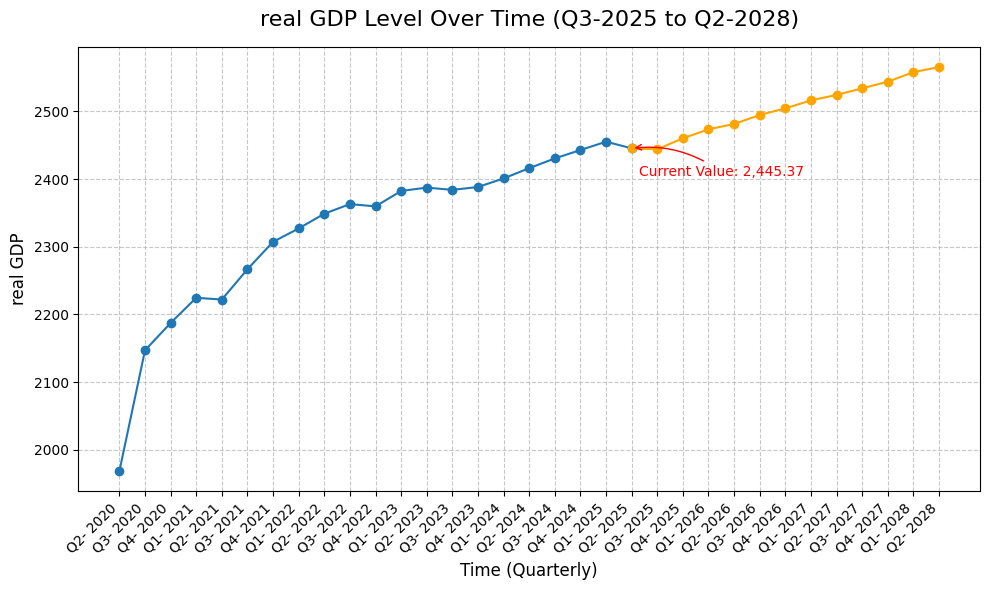

In [486]:
final_plotting(real_GDP, "real GDP")

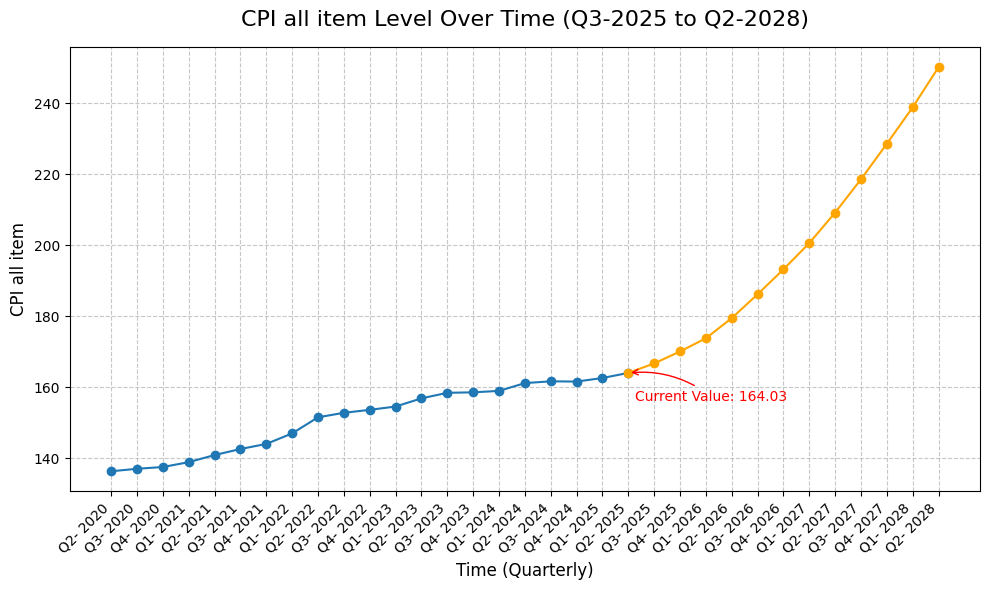

In [487]:
final_plotting(CPI_2nd_integration,"CPI all item")